In [144]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.io import loadmat
from numpy import linalg as la

# Anomaly Detection

In [4]:
data = loadmat('../Data/ex8data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [5]:
X=data['X']
Xval=data['Xval']
yval=data['yval']
X.shape

(307, 2)

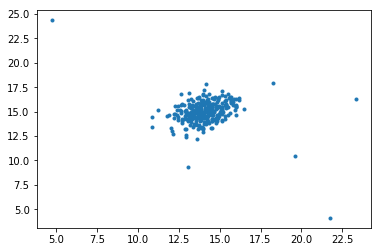

In [6]:
plt.scatter(X[:,0],X[:,1],marker='.')
plt.show()

Looks like some obvious anomalies. Let's see if we can detect them.

In [11]:
mu = X.mean(0)
sigma2 = X.std(0)**2

In [14]:
def gaussian(X,mu,sigma2):
    return np.exp(-(X-mu)**2/(2*sigma2))

In [12]:
p = np.prod(gaussian(X,mu,sigma2),axis=1)

In [17]:
edge = 1
x1,x2 = np.meshgrid(np.linspace(X[:,0].min()-edge,X[:,0].max()+edge,100),np.linspace(X[:,1].min()-edge,X[:,1].max()+edge,100))
prob_map = np.prod(gaussian(np.c_[x1.ravel(),x2.ravel()],mu,sigma2),axis=1).reshape(100,100)

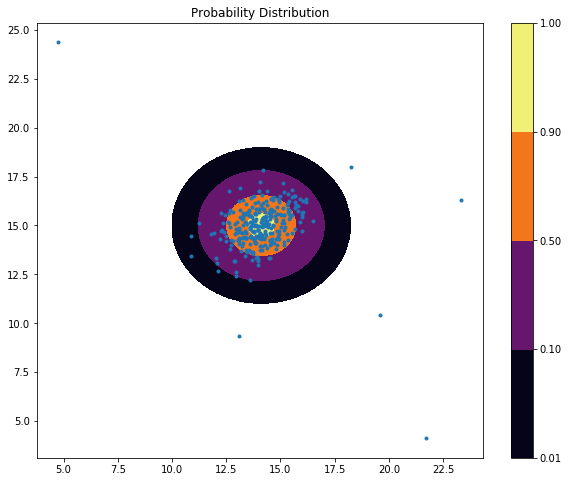

In [135]:
plt.figure(figsize=[10,8])
plt.contourf(x1,x2,prob_map,levels=[.01, .1, .5, .9, 1], cmap=plt.get_cmap('inferno'))
plt.colorbar()
plt.scatter(X[:,0],X[:,1],marker='.')
plt.title('Probability Distribution')
plt.show()

Just from this image, it seems pretty safe to set epsilon to be 0.01, but let's see what sort of procedure the instructions walk us through. However, this set of data isn't *supposed* to have anomalies, as they're supposed to be in the validation data.

In [28]:
pval = np.prod(gaussian(Xval,mu,sigma2),axis=1)

In [109]:
granularity = 6
eps_list = [10**(i/granularity) for i in range(-5*granularity,-2*granularity)]
fScoreList = []
for ie, eps in enumerate(eps_list):
    yGuess = pval<eps
    precision = sum(yGuess&yval.ravel())/sum(yGuess)
    recall = sum(yGuess&yval.ravel())/np.sum(yval)
    fScoreList.append(2*precision*recall/(precision+recall))

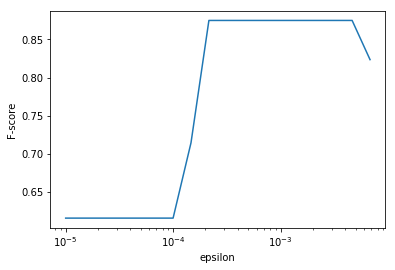

In [110]:
plt.plot(eps_list,fScoreList)
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('F-score')
plt.show()

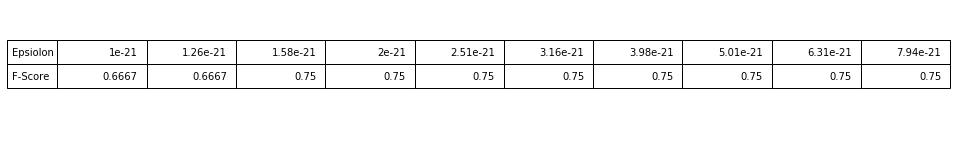

In [262]:
cell_text = [[f'{eps:.3}' for eps in eps_list], [f'{fScore:.4}' for fScore in fScoreList]]

fig, ax = plt.subplots(1,1, figsize = [16,2])
ax.axis('tight')
ax.axis('off')
tbl = ax.table(cellText=cell_text, rowLabels=['Epsiolon', 'F-Score'],loc='center')
tbl.scale(1,2)
plt.show()

I want the smallest epsilon that still captures the data, so from this data set that would be eps = 10**(-11/3) = 2.15e-4. It makes sense that the F-Score value would be so quantized, since there are so few anomalies to detect.

In [103]:
eps = 10**(-11/3)

In [104]:
yGuess = pval<eps

In [106]:
sum(yGuess&yval.ravel())/np.sum(yval)

0.7777777777777778

In [107]:
sum(yGuess&yval.ravel())/np.sum(yGuess)

1.0

In [108]:
np.sum(yval)

9

So I'm failing to find two anomalies, but everything that I label as an anomaly *is* an anomaly. The tolerance for this sort of error is very dependent on the purpose of the project, but for this exercise I was told to maximise F-score and this is the epsilon that does that. 

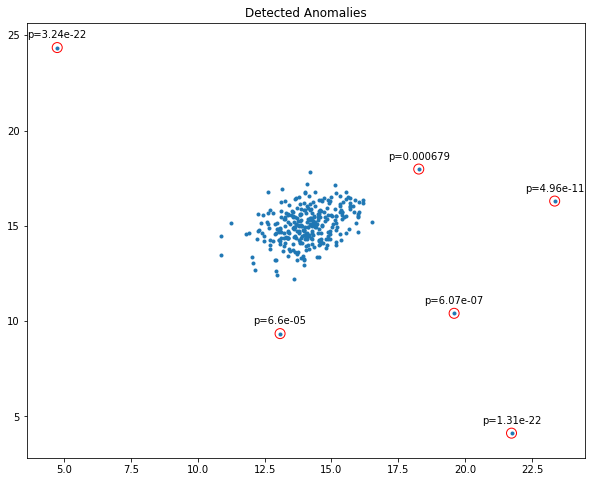

In [127]:
anom = p<eps
plt.figure(figsize=[10,8])
plt.scatter(X[:,0],X[:,1],marker='.')
plt.scatter(X[anom,0],X[anom,1],s=100,facecolor='none',edgecolor='r')
for ia, a in enumerate(anom):
    if a:
        plt.text(X[ia,0],X[ia,1]+.5,f'p={p[ia]:.3}',horizontalalignment='center')
plt.title('Detected Anomalies')
plt.show()

### More complex anomaly data (more features)

In [136]:
data = loadmat('../Data/ex8data2.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [137]:
X=data['X']
Xval=data['Xval']
yval=data['yval']
X.shape

(1000, 11)

The instructions want us to just use the implementation we already had, but instead I'm going to use this set to try a manual multi-dimentional gaussian and see what standard implementations there are. First I need to check how normally distributed are the data.

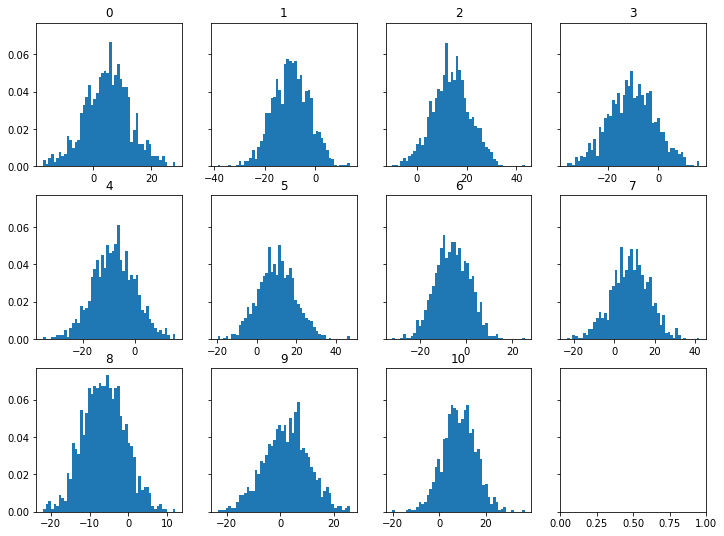

In [140]:
fig, ax = plt.subplots(3,4,figsize=[12,9],sharey=True)
ax = ax.ravel()
for i in range(11):
    ax[i].hist(X[:,i],bins=50,density=True)
    ax[i].set_title(f'{i}')
plt.show()
    

Yup, no tricks, all data is pretty normal.

In [245]:
m,n = X.shape
mu = X.mean(axis=0).reshape(1,n)
Sigma = np.sum((X-mu).reshape(m,n,1)@(X-mu).reshape(m,1,n),axis=0)/m
detSig = la.det(Sigma)
invSig = la.inv(Sigma)

In [251]:
pval = np.diag((detSig*(2*np.pi)**n)**(-1/2)*np.exp((-1/2)*((Xval-mu)@invSig@(Xval-mu).T)))

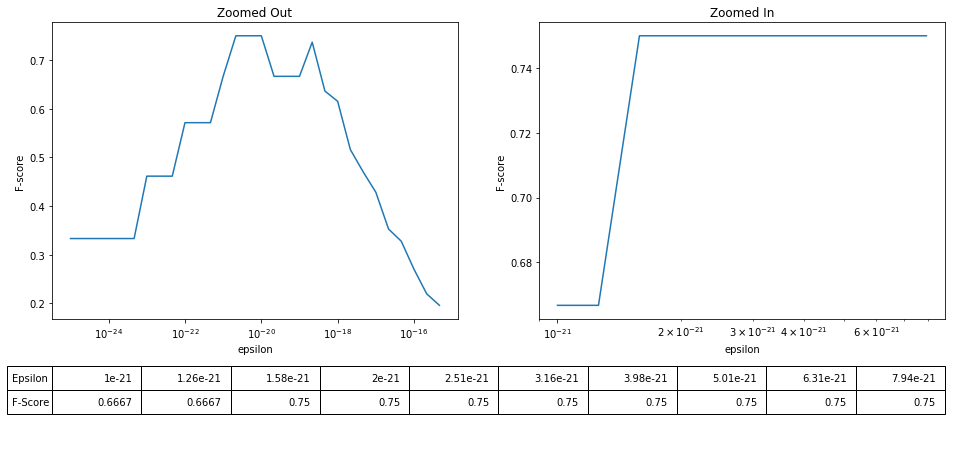

In [276]:
fig = plt.figure(figsize=[16,12])

granularity = 10
eps_list = [10**(i/granularity) for i in range(-21*granularity,-20*granularity)]
fScoreList = []
for ie, eps in enumerate(eps_list):
    yGuess = pval<eps
    precision = sum(yGuess&yval.ravel())/sum(yGuess)
    recall = sum(yGuess&yval.ravel())/np.sum(yval)
    fScoreList.append(2*precision*recall/(precision+recall))

cell_text = [[f'{eps:.3}' for eps in eps_list], [f'{fScore:.4}' for fScore in fScoreList]]
ax1 = plt.subplot(815)
ax1.axis('tight')
ax1.axis('off')
tbl = ax1.table(cellText=cell_text, rowLabels=['Epsilon', 'F-Score'],loc='center')
tbl.scale(1,2)

ax2 = plt.subplot(222)
ax2.plot(eps_list,fScoreList)
ax2.set_xscale('log')
ax2.set_xlabel('epsilon')
ax2.set_ylabel('F-score')
ax2.set_title('Zoomed In')


granularity = 3
eps_list = [10**(i/granularity) for i in range(-25*granularity,-15*granularity)]
fScoreList = []
for ie, eps in enumerate(eps_list):
    yGuess = pval<eps
    precision = sum(yGuess&yval.ravel())/sum(yGuess)
    recall = sum(yGuess&yval.ravel())/np.sum(yval)
    fScoreList.append(2*precision*recall/(precision+recall))

ax3 = plt.subplot(221)
ax3.plot(eps_list,fScoreList)
ax3.set_xscale('log')
ax3.set_xlabel('epsilon')
ax3.set_ylabel('F-score')
ax3.set_title('Zoomed Out')

plt.show()

The smallest eps that maximizes F-score is 10**-20.8 = 1.58e-21

In [283]:
eps = 10**-20.8
p = np.diag((detSig*(2*np.pi)**n)**(-1/2)*np.exp((-1/2)*((X-mu)@invSig@(X-mu).T)))
contamination = sum(p<eps)/m
print(f'The data contain {100*contamination:.3}% outliers')

The data contain 0.7% outliers


It seems there are [various methods for outlier detection](https://scikit-learn.org/stable/modules/outlier_detection.html), but for the sake of redundancy I'll try to implement the sklearn EllipticEnvelope function.

In [278]:
from sklearn.covariance import EllipticEnvelope

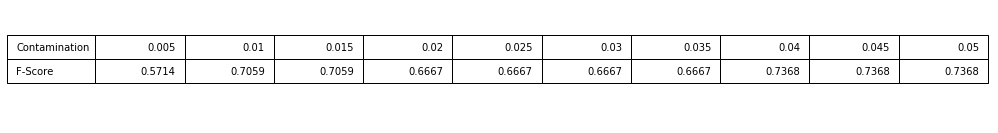

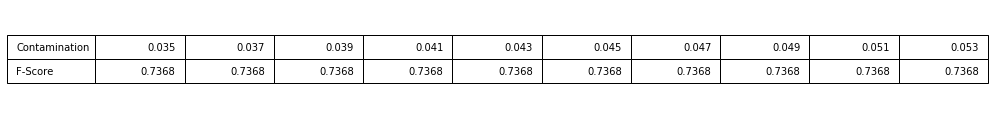

In [338]:
conList = [.005 + .005*i for i in range(10) ]
fList = []
for con in conList:
    EE = EllipticEnvelope(contamination=con)
    EE.fit(X)
    yGuessEE = (-(EE.predict(Xval)-1)/2)==1
    recall = sum(yGuessEE&yval.ravel())/np.sum(yval)
    precision = sum(yGuessEE&yval.ravel())/sum(yGuessEE)
    fList.append(2*precision*recall/(precision+recall))

plt.figure(figsize=[16,4])
cell_text = [[f'{con:.3}' for con in conList], [f'{fScore:.4}' for fScore in fList]]
ax1 = plt.subplot(211)
ax1.axis('tight')
ax1.axis('off')
tbl = ax1.table(cellText=cell_text, rowLabels=['Contamination', 'F-Score'],loc='center')
tbl.scale(1,2)

conList = [.035 + .002*i for i in range(10)]
fList = []
for con in conList:
    EE = EllipticEnvelope(contamination=con)
    EE.fit(X)
    yGuessEE = (-(EE.predict(Xval)-1)/2)==1
    recall = sum(yGuessEE&yval.ravel())/np.sum(yval)
    precision = sum(yGuessEE&yval.ravel())/sum(yGuessEE)
    fList.append(2*precision*recall/(precision+recall))

cell_text = [[f'{con:.3}' for con in conList], [f'{fScore:.4}' for fScore in fList]]
ax1 = plt.subplot(212)
ax1.axis('tight')
ax1.axis('off')
tbl = ax1.table(cellText=cell_text, rowLabels=['Contamination', 'F-Score'],loc='center')
tbl.scale(1,2)

So it appears that this method is sensitive to the contamination value AND the F-score isn't as good as my implementation. That probalby means that I usually wouldn't want to use this implementation, and there are many reasons.
1. It's not as good as the manual implementation...
    * and the manual implementation is pretty easy.
2. There are 3 other outlier detection schemes in sklearn...
    * and they all seem to work better on the toy data set.
    
In the end, from personal experience, I know that outlier detection is very hard, so I can't fault this too much. If I ever had to tackle the problem professionally, I'd have to read up on the most up-to-date methodologies.

# Recommender Systems
It seems there is no sklearn implementation, and I'm a bit hesitant to dive back into my gradient descent code and try to program all the functions for this (since the course provides Matlab code with most of that stuff worked out already). So maybe, since this is the last task in this course, I can try to come up with something to do for manual implementation and then also explore external implementations.

First, let's see what I'm working with.

In [340]:
movies = loadmat('../Data/ex8_movies.mat')
movies.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [376]:
Y = movies['Y'] #ratings, indexed by (movie, user)
R = movies['R'] #has user seen movie
print(f'Y shape is {Y.shape} and R shape is the same.')

Y shape is (1682, 943) and R shape is the same.


In [347]:
movieParams = loadmat('../Data/ex8_movieParams.mat')
movieParams.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [377]:
X = movieParams['X'] # movie feature vector
Theta = movieParams['Theta'] #user feature vector
print(f'X shape is {X.shape} and Theta shape is {Theta.shape}.')

X shape is (1682, 10) and Theta shape is (943, 10).


In [371]:
nm, nu = R.shape #num movies, num users
nf = X.shape[1] #num features (a free variable)
print(f'Numer of users: {nu}\nNumber of movies: {nm}\nNumber of features: {nf}')

Numer of users: 943
Number of movies: 1682
Number of features: 10


In [380]:
def costFunction(X,Y,Theta,R): #ignoring some constants
    return np.sum(R*(X@Theta.T-Y)**2)

In [381]:
costFunction(X,Y,Theta,R)

55837.28024908842

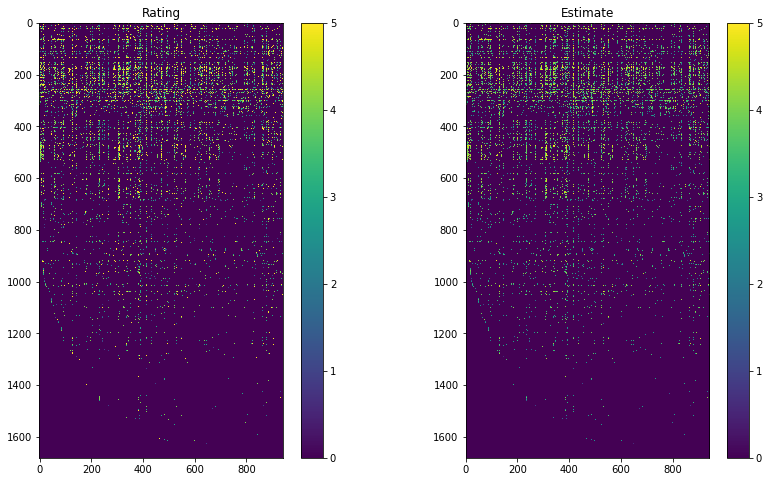

In [397]:
plt.figure(figsize=[14, 8])
ax1 = plt.subplot(121)
im1 = ax1.imshow(Y)
plt.colorbar(mappable=im1, ax=ax1)
ax1.set_title('Rating')
ax2 = plt.subplot(122)
im2 = ax2.imshow(R*(X@Theta.T),vmin=0,vmax=5)
plt.colorbar(mappable=im2, ax=ax2)
ax2.set_title('Estimate')

plt.show()

Well, the instructions suggest getting a cost of 22.22, and mine is nowhere near that. I can't see anything wrong with what I did, and via this visualization I think the values are pretty close. But there's 100,000 ratings, so to get a cost of 22.22 would require an accuracy of approx 99.99%. If we were already that close, then I can't imagine this being an interesting dataset. Maybe that's the kind of error I should expect after training it? Or maybe their algorithm just has some normalization that mine doesn't have.

In [408]:
gradTheta = np.sum(X.T@(R*(X@Theta.T-Y)),axis=1).reshape(1,-1)

In [410]:
gradX = np.sum((R*(X@Theta.T-Y)@Theta),axis=1).reshape(1,-1)